# Contexto

Nesse projeto, foi estudada a base de dados Telco Customer Churn, do Kaggle. Essa base apresenta características sobre clientes da empresa e o objetivo da modelagem é prever se um cliente fará ou não Churn (cancelamento do serviço).

Para trabalhar, foi seguida a medologia OSEMN (Obtain, Scrub, Explore, Model and iNterpret).

## Etapa 0 - Importação de bibliotecas e funções auxiliares

In [26]:
import os
import pickle
import warnings
import researchpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from xgboost import XGBClassifier
from scipy.stats import skew, kurtosis
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [27]:
#funções auxiliares

def estatisticas(df):
    """
    Calcula algumas estatísticas descritivas sobre as variáveis numéricas de uma base de dados.
    É apenas uma incrementação do método describe() da biblioteca pandas.
    """
    
    d = df.describe(include='all')
    d.loc['skewness'] = skew(df)
    d.loc['kurtosis'] = kurtosis(df)
    
    return d

def cramer_v_index(v1, v2):
    """
    Calcula o índice V de Cramer entre duas variáveis nominais.
    """
    
    crosstab, res = researchpy.crosstab(v1, v2, test='chi-square')
    
    return res['results'][2]

def cramer_v_matrix(df):
    """
    Monta a matriz de correlação entre variáveis categóricas de uma base de dados utilizando o índice V de Cramer.
    """
    
    colunas = list(df.columns)
    combinacao_variaveis = list( product(colunas, colunas) )
    corr_values = []
    N = len(colunas)

    for comb in combinacao_variaveis:
        corr_values.append( cramer_v_index(df[comb[0]], df[comb[1]]) )
    
    corr_values = np.array(corr_values).reshape(N, N)

    res = pd.DataFrame(corr_values, index = colunas, columns = colunas)
    
    return res

def get_n_most_corr_pairs(cm, n, annot = False):
    """
    Seleciona os n pares de variáveis com maior índice (absoluto) de correlação.
    """
    
    corr_matrix = cm.abs()
    
    s = pd.DataFrame((corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                                        .astype(bool))
                      .stack()
                      .sort_values(ascending=False))).reset_index()
    s.columns = ['var1', 'var2', 'corr']
    
    return s.iloc[0:n, :]

def metricas_classificacao(X, y, model, k = 10):
    """
    Calcula, para um determinado modelo de classificação, as métricas acurácia, precisão, recall e F1-score.
    Utiliza, para separação dos dados, a estratégia Stratified K-Fold, com k = 10 por padrão.
    """
    
    kf = StratifiedKFold(k)
    model_name = type(model).__name__
    
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train = X.iloc[train_index, :] 
        y_train = np.array( y.iloc[train_index] )
        X_test = X.iloc[test_index, :]
        y_test = np.array ( y.iloc[test_index] )
    
        #treinamento
        model.fit(X_train, y_train)

        #predição
        y_pred = model.predict(X_test)

        #métricas
        accuracy_list.append( accuracy_score(y_test, y_pred) )
        precision_list.append( precision_score(y_test, y_pred) )
        recall_list.append( recall_score(y_test, y_pred) )
        f1_score_list.append( f1_score(y_test, y_pred) )

    result = pd.DataFrame(index = [], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    result.loc[0, :] = [model_name,
                        np.mean(accuracy_list),
                        np.mean(precision_list),
                        np.mean(recall_list),
                        np.mean(f1_score_list)] 
    return result

## Etapa 1 - Obtain/Obtenção

Nesse caso em específico, a obtenção é simples, pois basta carregar a base de dados já fornecida na competição. Em contextos reais, é comum precisar realizar *web scraping*, que consiste em uma raspagem/coleta dos dados brutos diretamente de algum site ou outra fonte.

In [4]:
# Pegando o caminho absoluto dos dados
ROOT_DIR = os.getcwd()
DATA_DIR = ROOT_DIR + '\data\churn.csv'

df = pd.read_csv(DATA_DIR)

In [5]:
# Visão geral da base de dados
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Etapa 2 - Scrub/Limpeza

In [7]:
# Visão geral sobre os tipos de dados de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Aqui, já podemos observar alguns pontos que merecem atenção:

1. A coluna 'SeniorCitizen' apresenta tipo **int64**. Apesar de ser marcada com 1 e 0, é uma variável categórica.
2. A coluna 'TotalCharges' apresenta tipo **object**, geralmente utilizado para *strings*, mas é uma variável numérica.

Vamos investigar esses problemas.

Em primeira instância, podemos excluir a coluna de identificação do usuário, que não irá nos trazer informação relevante para esse problema.

In [28]:
df.drop('customerID', axis=1, inplace=True)

In [29]:
#Mudando o tipo de dados da coluna SeniorCitizen
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [30]:
#investigando os valores presentes na coluna TotalCharges
df['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

Como podemos ver, existem 11 registros com o caractere vazio ' '. 

Isso é um ocorrido comum em problemas reais. Nem sempre um dado faltante está representado como o tipo NaN, que seria o ideal. Podemos encontrá-lo como um caractere como '-', '.', '?', e outros, por isso é importante se atentar a esses detalhes.

In [31]:
#substituindo o caractere ' '(vazio) pelo tipo Not a Number do python e transformando a coluna para o tipo esperado.
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.NaN).astype('float64')

Uma boa prática também é checar se há registros duplicados na base.

In [32]:
print(f'Há {sum(df.duplicated())} registros duplicados na base')

Há 22 registros duplicados na base


Como representam uma quantidade pequena, também iremos exclui-los.

In [33]:
df.drop_duplicates(inplace=True)

Por fim, iremos tratar os dados faltantes encontrados. Como a quantidade de dados faltantes representa uma porção muito pequena da nossa base, optei por excluí-los.

In [34]:
df.dropna(inplace=True)

Agora, checamos novamente a informação geral dos dados para verificar se os problemas encontrados foram corrigidos.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7010 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7010 non-null   object 
 1   SeniorCitizen     7010 non-null   object 
 2   Partner           7010 non-null   object 
 3   Dependents        7010 non-null   object 
 4   tenure            7010 non-null   int64  
 5   PhoneService      7010 non-null   object 
 6   MultipleLines     7010 non-null   object 
 7   InternetService   7010 non-null   object 
 8   OnlineSecurity    7010 non-null   object 
 9   OnlineBackup      7010 non-null   object 
 10  DeviceProtection  7010 non-null   object 
 11  TechSupport       7010 non-null   object 
 12  StreamingTV       7010 non-null   object 
 13  StreamingMovies   7010 non-null   object 
 14  Contract          7010 non-null   object 
 15  PaperlessBilling  7010 non-null   object 
 16  PaymentMethod     7010 non-null   object 


Podemos ver que foram excluídos os registros com dados faltantes e os tipos de dados também foram corrigidos. Como não foram encontradas mais inconsistências na base de dados, podemos prosseguir para a próxima etapa.

## Etapa 3 - Explore/Exploração

Na etapa de exploração, são realizadas verificações estatísticas sobre os dados para que haja a formulação de hipóteses sobre eles.

In [36]:
#variáveis numéricas
numericas = df.select_dtypes(include = np.number).columns.tolist()

#variáveis categóricas, excluindo a coluna target do nosso problema
categoricas = df.drop('Churn', axis = 1).select_dtypes(include = object).columns.tolist()

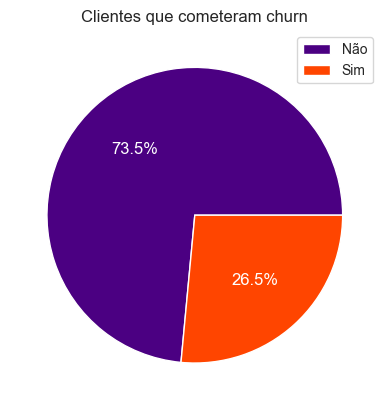

In [37]:
#Checando a distribuição da variável alvo

plt.pie(x = df['Churn'].value_counts(), 
        labels = ['Não', 'Sim'], 
        colors = ['indigo', 'orangered'], 
        autopct='%1.1f%%', 
        textprops={'color':"w", 'fontsize': 12})

plt.title('Clientes que cometeram churn')
plt.legend()

plt.show()

Como podemos notar, existe um certo **desbalanceamento nos dados**, como esperado nessa situação de Churn. Os clientes que realizaram Churn representam cerca de 26,5% da amostra. Não é um desbalanceamento exageradamente acentuado, mas ainda é algo que podemos dar atenção. Será explorado na etapa 4.

## 3.1. Análise univariada

In [18]:
# Visão geral de estatísticas básicas sobre os dados

estatisticas(df[numericas])

,tenure,MonthlyCharges,TotalCharges
count,7010.000000,7010.000000,7010.000000
mean,32.520399,64.888666,2290.353388
std,24.520441,30.064769,2266.820832
min,1.000000,18.250000,18.800000
25%,9.000000,35.750000,408.312500
50%,29.000000,70.400000,1403.875000
75%,56.000000,89.900000,3807.837500
max,72.000000,118.750000,8684.800000
skewness,0.233690,-0.225638,0.958117
kurtosis,-1.388391,-1.252806,-0.239059


Através das estatísticas _skewness_ (assimetria) e _kurtosis_ (curtose) podemos chegar às seguintes conclusões:

**Sobre assimetria**:
- As variáveis tenure e TotalCharges apresentam uma assimetria **positiva**, ou seja, os dados estão um pouco mais concentrados **abaixo** da média, mas em TotalCharges isso é mais acentuado.
- A variável MonthlyCharges apresenta uma assimetria **negativa**, ou seja, os dados estão um pouco mais concentrados **acima** da média.

**Sobre curtose**:
- Ambas as variáveis apresentam um valor de curtose **menor que 3**, ou seja, a curva da distribuição é mais "achatada". Isso significa que os dados estão bem distribuídos. Porém, na variável TotalCharges, isso é mais suave.

Podemos comprovar as informações levantadas mostrando os gráficos de distribuição para cada variável.

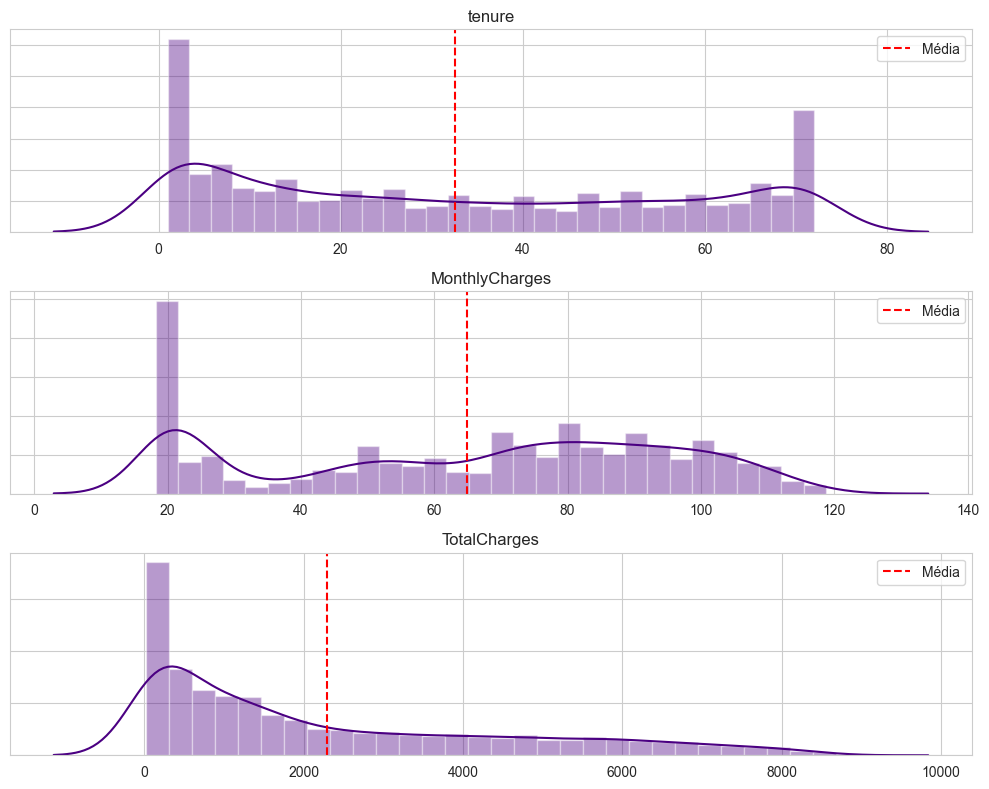

In [19]:
fig, axes = plt.subplots(3, 1, figsize = (10,8))

for var, ax in zip(numericas, range(3)):
    sns.distplot(df[var], ax = axes[ax], bins = 30, color='indigo').set(xlabel=None,
                                                                      ylabel=None,
                                                                      yticklabels=[])
    axes[ax].set_title(var)
    v = axes[ax].axvline(np.mean(df[var]), color='red', linestyle='--', label = 'Média')
    axes[ax].legend(handles=[v], labels=['Média'])

fig.tight_layout()

### 3.2. Variáveis categóricas

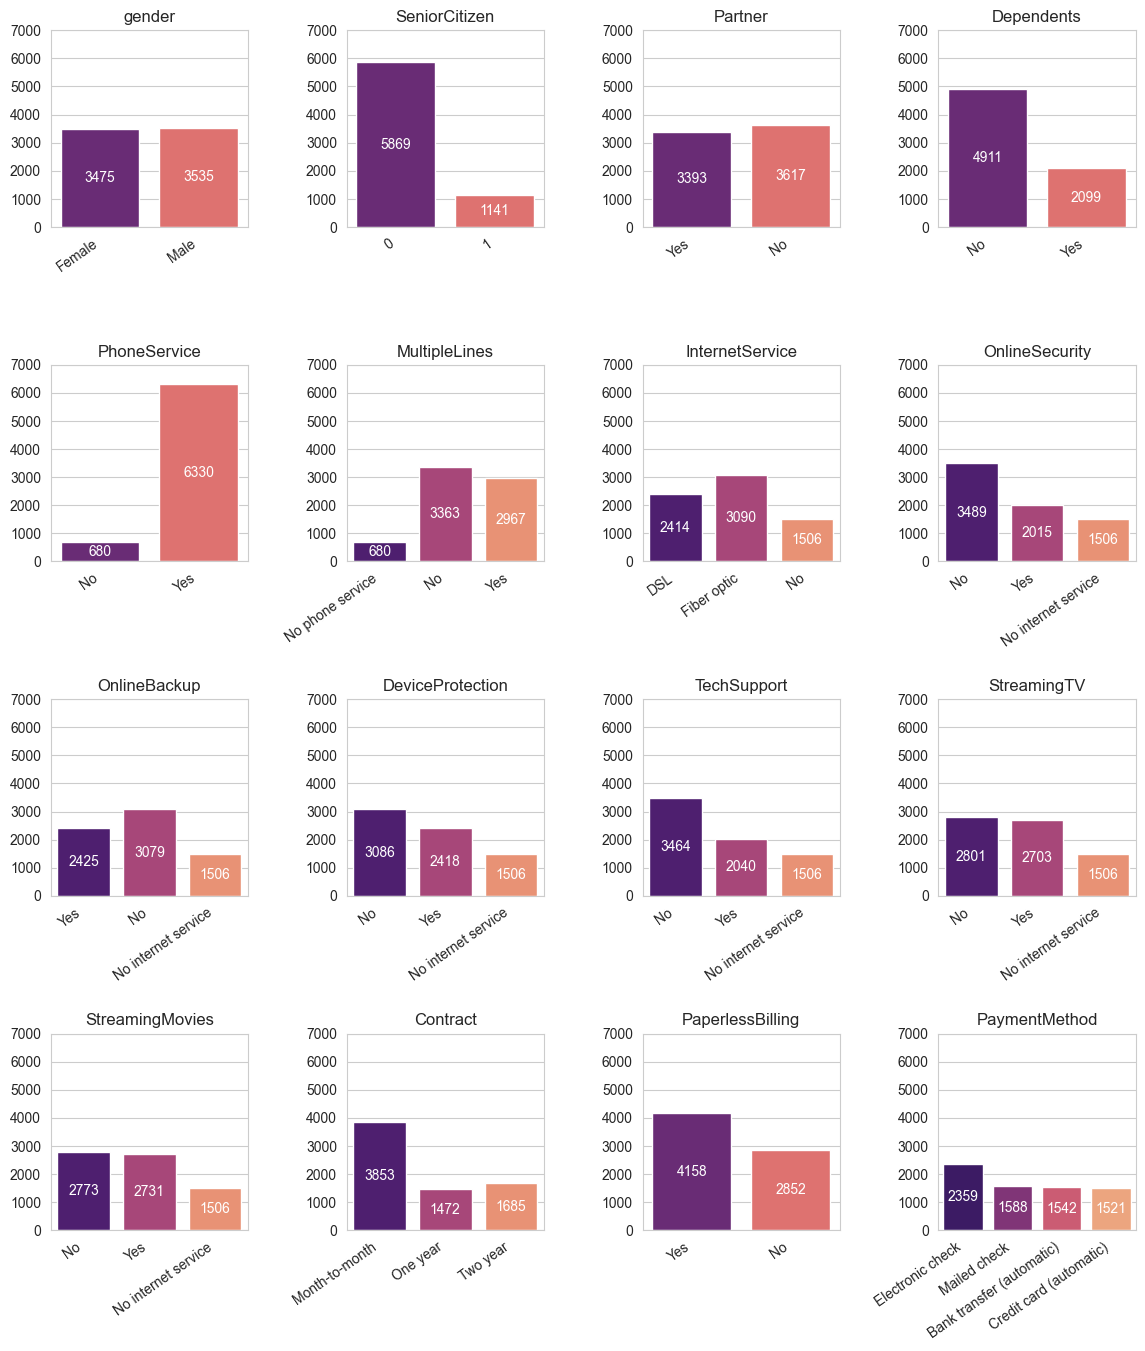

In [20]:
#Para as variáveis categóricas, checamos como está sua distribuição

fig, axes = plt.subplots(4, 4, figsize = (14, 15))

#índices dos subplots
count = list( product( list(range(4)), list(range(4)) ) )

for var, ax in zip(categoricas, count):
    sns.countplot(x = df[var], ax = axes[ax], palette = 'magma')
    
    axes[ax].set(title = var, xlabel=None, ylabel=None, ylim = [0, 7000])
    axes[ax].set_xticklabels(axes[ax].get_xticklabels(), rotation=35, ha='right')
    axes[ax].bar_label(axes[ax].containers[0], label_type='center', color='white')
 
plt.subplots_adjust(left=None, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.7)

Em uma primeira análise na distribuição de cada variável, podemos notar que a grande maioria dos clientes:

- Não são idosos
- Não possuem dependentes
- Possuem serviço de telefone

### 3.2. Análise multivariada

Nesta etapa, vamos procurar relação numérica entre as variáveis.

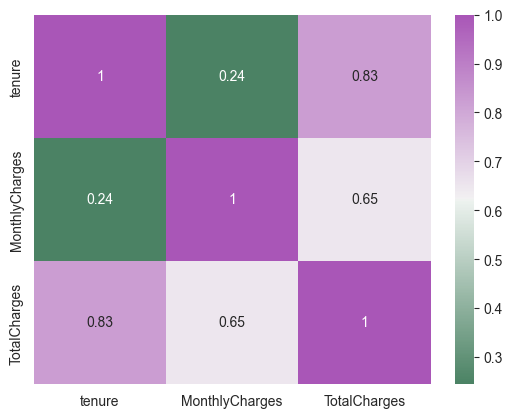

In [21]:
#Correlação entre as variáveis numericas
mypalette = sns.diverging_palette(145, 300, s=60, as_cmap=True)

sns.heatmap(df.corr(), cmap = mypalette, annot = True)

plt.show()

Como podemos ver, existe uma **forte correlação (0.83)** entre as variáveis tenure e TotalCharges. Isso pode gerar um problema em alguns algoritmos. Será explorado na etapa 4.

Na literatura, existem alguns índices utilizados para calcular **correlação entre variáveis categóricas**. Para o nosso problema iremos utilizar o índice V de Cramer, que é mais adequado para variáveis categóricas nominais, ou seja, não há hierarquia entre os valores.

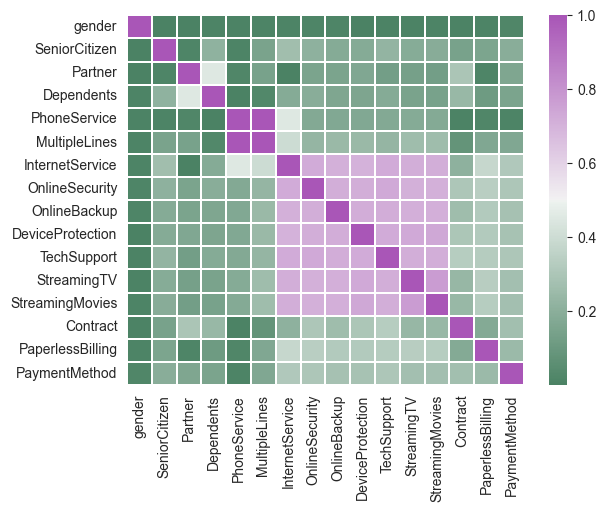

<Figure size 2000x2000 with 0 Axes>

In [22]:
cvm = cramer_v_matrix(df[categoricas])
mypalette = sns.diverging_palette(145, 300, s=60, as_cmap=True)

sns.heatmap(cvm, cmap = mypalette, linewidths=.3)
plt.figure(figsize = (20, 20))

plt.show()

Diferente do caso das variáveis numéricas, neste, é mais difícil fazer uma análise visual das correlações, pois temos uma matriz 16x16. Podemos utilizar uma função auxiliar para saber quais os pares de variáveis que apresentam maior correlação.

In [23]:
#Para esse caso, vamos checar os 10 maiores índices de correlação
get_n_most_corr_pairs(cvm, 10)

,var1,var2,corr
0,PhoneService,MultipleLines,1.0000
1,StreamingTV,StreamingMovies,0.7710
2,DeviceProtection,StreamingMovies,0.7360
3,DeviceProtection,StreamingTV,0.7334
4,OnlineSecurity,TechSupport,0.7329
5,DeviceProtection,TechSupport,0.7263
6,InternetService,OnlineSecurity,0.7243
7,InternetService,TechSupport,0.7228
8,OnlineBackup,TechSupport,0.7197
9,OnlineBackup,DeviceProtection,0.7190


Observamos que também há variáveis com alta correlação entre si.

## Etapa 4 - Model/Modelagem

### 4.1. Preparação dos dados
Nesta etapa, buscamos deixar os dados em um formato mais adequado para os modelos de Machine Learning. Como iremos fazer transformações na base, o ideal é fazer uma cópia para que fique mais fácil desfazer uma eventual mudança, caso desejado.

In [38]:
df1 = df.copy()

In [39]:
#Checando novamente a base de dados
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [40]:
print(f'Range das variáveis numéricas:\n\n {df[numericas].max() - df[numericas].min()}') 

Range das variáveis numéricas:

 tenure              71.0
MonthlyCharges     100.5
TotalCharges      8666.0
dtype: float64


Algumas observações:

- A escala entre as variáveis numéricas varia bastante, então pode ser que normalizar os dados seja benéfico.
- Temos dois formatos de variáveis categóricas: com os próprios rótulos e com os rótulos representados como 0 e 1, como em SeniorCitizen. O ideal é que estejam todas em formato numérico.
- A variável alvo também apresenta rótulos.

In [41]:
#Normalizando os dados:
scaler = MinMaxScaler()

df1[numericas] = scaler.fit_transform(df1[numericas])

No encoding das variáveis categóricas, tentamos adequar o dataset para o formato do nosso problema, sem aumentar muito a dimensionalidade dos dados e sem perder informação. Assim, iremos fazer o One Hot Encoding seguindo a seguinte regra:

- Se for binária (apenas 2 valores), dropamos a primeira coluna, deixando apenas uma.
- Se não for binária, deixamos todas as colunas.

In [42]:
#verificando quais colunas são binárias ou não
unique_values = pd.DataFrame(df1[categoricas].nunique()).reset_index()
unique_values.columns = ['var', 'count']

columns_to_drop_first = unique_values['var'].loc[unique_values['count'] <= 2].values

columns_to_leave_first = unique_values['var'].loc[unique_values['count'] > 2].values

#fazendo o encoding das variáveis
df1 = pd.get_dummies(df1, columns = columns_to_drop_first, drop_first = True)

df1 = pd.get_dummies(df1, columns = columns_to_leave_first, drop_first = False)

#fazendo o encoding da variável alvo
df1['Churn'] = df1['Churn'].apply(lambda x: 0 if x == 'No' else 1)

#verificando o resultado final do dataset após as transformações
df1.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.000000,0.115423,0.001275,0,0,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1,0.464789,0.385075,0.215867,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,0.014085,0.354229,0.010310,1,1,0,0,0,1,1,...,1,0,0,1,0,0,0,0,0,1
3,0.619718,0.239303,0.210241,0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
4,0.014085,0.521891,0.015330,1,0,0,0,0,1,1,...,1,0,0,1,0,0,0,0,1,0


### 4.2. Modelos de Machine Learning

Inicialmente, testaremos os modelos MLP e XGBoost. Para validação, optei pelo StratifiedKFold, pelo fato das classes serem desbalanceadas.

In [55]:
X = df1.drop('Churn', axis = 1)
y = df1['Churn']

mlp = MLPClassifier(max_iter=100)
xgb = XGBClassifier()

Verificando a performance dos modelos

In [52]:
metricas_mlp = metricas_classificacao(X, y, mlp)
metricas_xgb = metricas_classificacao(X, y, xgb)

metricas = metricas_mlp.append(metricas_xgb)
metricas

,Model,Accuracy,Precision,Recall,F1 Score
0,MLPClassifier,0.78873,0.615017,0.547094,0.577879
0,XGBClassifier,0.786733,0.618653,0.511584,0.559568


Nesse problema, daremos mais atenção às métricas recall e F1-score, pois queremos que o modelo faça a predição mais correta possível entre as amostras que apresentam a classe 1, ou seja, queremos reduzir os falsos negativos. Como podemos ver, o resultado foi ruim, pois temos um modelo quase equivalente à aleatoriedade.

Algo a se chamar atenção é que a acurácia apresenta um resultado razoável, mas o recall e o F1-score não, o que nos alerta para um possível problema causado pelo **desbalanceamento entre as classes**. Sendo assim, podemos utilizar estratégias para resolver isso.

### 4.3. Balanceamento de classes
Existem algumas estratégias para lidar com bases de dados desbalanceadas. Para esse problema, decidi usar o Random Oversampling, que consiste em replicar as amostras da classe minoritária até ter uma proporção igual das classes.

In [49]:
df2 = df1.copy()

oversample = SMOTE()

X1 = df2.drop('Churn', axis = 1)
y1 = df2['Churn']

X1, y1 = oversample.fit_resample(X1, y1)

#proporção de classes após o balanceamento
y1.value_counts()

0    5153
1    5153
Name: Churn, dtype: int64

Testando os modelos com os novos dados

In [54]:
metricas_mlp = metricas_classificacao(X1, y1, mlp)
metricas_xgb = metricas_classificacao(X1, y1, xgb)

metricas = metricas_mlp.append(metricas_xgb)
metricas

,Model,Accuracy,Precision,Recall,F1 Score
0,MLPClassifier,0.833127,0.82014,0.849776,0.831046
0,XGBClassifier,0.846132,0.834775,0.860636,0.841977


Como podemos notar, houve uma melhora significativa nos resultados, mesmo com os modelos utilizando os hiperparâmetros padrão. Podemos modificá-los no intuito de melhorar um pouco as métricas.

### 4.4. Otimização de hiperparâmetros

Por uma certa limitação de hardware, optei por utilizar a estratégia Random Search, que seleciona aleatoriamente n combinações de atributos, em vez do Grid Search, que testa todas as combinações possíveis.

In [71]:
parameters_xgb = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'eta': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.3, 0.7],
    'min_child_weight': [3, 10]
}

parameters_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.005],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

In [75]:
rs_xgb = RandomizedSearchCV(xgb, parameters_xgb, n_iter = 50, verbose = 4, scoring = 'recall', n_jobs = -1)
search_xgb = rs_xgb.fit(X1, y1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [76]:
rs_mlp = RandomizedSearchCV(mlp, parameters_mlp, n_iter = 50, verbose = 4, scoring = 'recall', n_jobs = -1)
search_mlp = rs_mlp.fit(X1, y1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [77]:
best_params_xgb = search_xgb.best_params_
best_params_xgb

{'subsample': 0.7,
 'n_estimators': 1000,
 'min_child_weight': 3,
 'max_depth': 7,
 'eta': 0.01,
 'colsample_bytree': 0.3}

In [78]:
best_params_mlp = search_mlp.best_params_
best_params_mlp

{'solver': 'adam',
 'learning_rate': 'constant',
 'hidden_layer_sizes': (50, 50, 50),
 'alpha': 0.005,
 'activation': 'tanh'}

In [89]:
#Criando os modelos com os melhores parâmetros encontrados pelo RandomSearch

xgb_tuned = XGBClassifier(
    subsample = 0.7,
    n_estimators = 1000,
    min_child_weight = 3,
    max_depth = 7,
    eta = 0.01,
    colsample_bytree = 0.3
)

mlp_tuned = MLPClassifier(
    solver = 'adam',
    learning_rate = 'constant',
    hidden_layer_sizes = (50, 50, 50),
    alpha = 0.005,
    activation = 'tanh'
)

In [90]:
metricas_mlp = metricas_classificacao(X1, y1, mlp_tuned)
metricas_xgb = metricas_classificacao(X1, y1, xgb_tuned)

metricas = metricas_mlp.append(metricas_xgb)
metricas

,Model,Accuracy,Precision,Recall,F1 Score
0,MLPClassifier,0.828275,0.810876,0.853461,0.827322
0,XGBClassifier,0.83322,0.809563,0.870155,0.836504


Seguirei no projeto com o modelo XGBClassifier, que apresentou 87% de recall.

In [114]:
#exportando o modelo

filename = 'finalized_model.sav'
MODEL_DIR = ROOT_DIR + '\model\\' + filename

pickle.dump(xgb_tuned, open(MODEL_DIR, 'wb'))

## Etapa 5 - Interpret/Interpretação

Na etapa de interpretação, iremos simular o cadastro de um novo cliente no sistema e predizer a chance dele fazer Churn, para ver uma aplicação prática do modelo criado.

Disponível em https://churn-analysis-eloabe.streamlit.app/